In [1]:
!pip install boto3 sagemaker pandas scikit-learn

### Read the dataset

In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Connect of create an S3 Bucket

1. Split the dataset into train and test
2. Store train and test on S3

In [2]:
import boto3
from botocore.exceptions import ClientError

bucket_name = 'example-bucket-davidres'
s3 = boto3.resource('s3')

def create_bucket_if_not_exists(bucket_name):
    try:
        # Check if the bucket already exists
        s3.meta.client.head_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' already exists.")
    except ClientError:
        # If a client error is thrown, then the bucket does not exist
        try:
            s3.create_bucket(Bucket=bucket_name)
            print(f"Bucket '{bucket_name}' created.")
        except ClientError as e:
            print(f"Error creating bucket: {e}")

create_bucket_if_not_exists(bucket_name)

Bucket 'example-bucket-davidres' already exists.


## Store the dataset on S3 Bucket

1. Split the dataset into train and test
2. Store train and test on S3

In [3]:
train_data = pd.concat([y_train, X_train], axis=1)
test_data = pd.concat([y_test, X_test], axis=1)

train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)

s3.Bucket(bucket_name).upload_file('train.csv', 'train/train.csv')
s3.Bucket(bucket_name).upload_file('test.csv', 'test/test.csv')

### Create and Train an XGBoost Model

In [8]:
# Import the SageMaker library
import sagemaker

# Import the get_execution_role function from SageMaker, which retrieves the current IAM role
from sagemaker import get_execution_role

# Import the TrainingInput class, used to specify the training data location and format
from sagemaker.inputs import TrainingInput 

# Retrieve the IAM role associated with the SageMaker notebook instance
role = get_execution_role()

# Specify the S3 location and content type for the training data
s3_input_train = TrainingInput(s3_data=f's3://{bucket_name}/train/train.csv', content_type='csv')

# Specify the S3 location and content type for the test data
s3_input_test = TrainingInput(s3_data=f's3://{bucket_name}/test/test.csv', content_type='csv')


# Create an Estimator object for the XGBoost algorithm
xgb = sagemaker.estimator.Estimator(
    image_uri=sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, '1.0-1'),  # Specify the XGBoost container image URI
    role=role,  # IAM role to access AWS resources
    instance_count=1,  # Number of instances to use for training
    instance_type='ml.m4.xlarge',  # Instance type for training (ensure it fits within free tier limits)
    output_path=f's3://{bucket_name}/output'  # S3 location to store the output model artifacts
)


# Set hyperparameters for the XGBoost model
xgb.set_hyperparameters(
    objective='multi:softmax',  # Objective function for multi-class classification
    num_class=3,  # Number of classes in the target variable
    num_round=100  # Number of boosting rounds (iterations)
)

# Start the training job, specifying the training and validation data inputs
xgb.fit({'train': s3_input_train, 'validation': s3_input_test})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-07-04-15-20-30-875


2024-07-04 15:20:31 Starting - Starting the training job...
2024-07-04 15:20:50 Starting - Preparing the instances for training...
2024-07-04 15:21:13 Downloading - Downloading input data...
2024-07-04 15:21:43 Downloading - Downloading the training image......
2024-07-04 15:22:55 Training - Training image download completed. Training in progress.
2024-07-04 15:22:55 Uploading - Uploading generated training model[2024-07-04 15:22:50.586 ip-10-2-246-86.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root

### Deploy the XGBoost Model

In [9]:
predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-07-04-15-29-01-261
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-07-04-15-29-01-261
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-07-04-15-29-01-261


-------!

In [15]:
predictor.endpoint_name

'sagemaker-xgboost-2024-07-04-15-29-01-261'

### Make Predictions

In [19]:
# Import csv serializer
from sagemaker.serializers import CSVSerializer

# set the serializer type
predictor.serializer = CSVSerializer()

In [20]:
predictions = predictor.predict(X_test.to_numpy())
print(predictions)

b'1.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0'


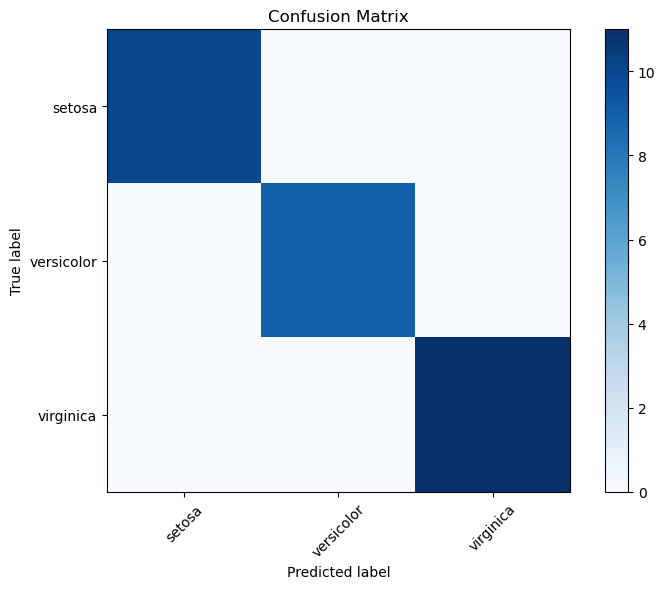

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

AUC for class setosa: 1.00
AUC for class versicolor: 1.00
AUC for class virginica: 1.00


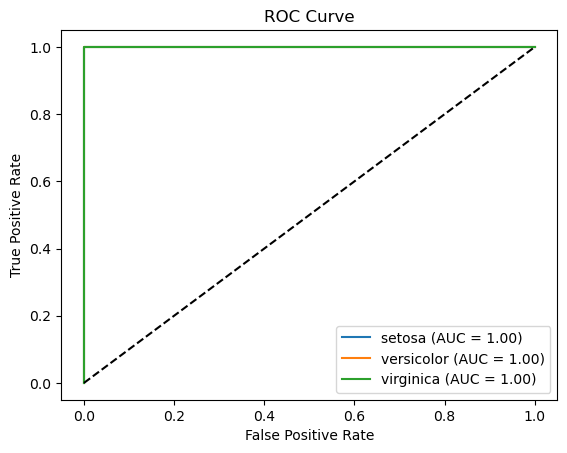

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Convert predictions from byte string to integer array
predictions = np.array(predictions.decode('utf-8').split(',')).astype(float).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(iris.target_names))
plt.xticks(tick_marks, iris.target_names, rotation=45)
plt.yticks(tick_marks, iris.target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=iris.target_names))

# AUC Score and ROC Curve
# Note: AUC calculation requires binary or multilabel-indicator format. This is a multi-class problem.
# We'll calculate AUC for each class against the rest.
y_test_bin = pd.get_dummies(y_test)
y_pred_bin = pd.get_dummies(predictions)

# Calculate AUC for each class
for i, class_name in enumerate(iris.target_names):
    auc = roc_auc_score(y_test_bin.iloc[:, i], y_pred_bin.iloc[:, i])
    print(f'AUC for class {class_name}: {auc:.2f}')

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_pred_bin.iloc[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

### Turn off Endpoint

In [29]:
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-xgboost-2024-07-04-15-29-01-261
INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2024-07-04-15-29-01-261
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-07-04-15-29-01-261
